# Setup

In [1]:
include(joinpath("..","src","setup.jl"))
R"library(ggplot2)"

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v0.7/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1185


RObject{StrSxp}
[1] "ggplot2"   "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     


In [103]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:t_c_m] - 32) < 1 &&
  abs(row[:t_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

params[:t_W_m_σ_t] = 7.0
params[:t_W_m_σ_ϕ] = 7.0
params[:t_W_m_c] = 4.0

# just a guess for now, think through this, and the specific inhibition function
# later, if using N works out
params[:W_m_σ_N] = 3

3

# proof of conecpt

In [104]:
result = []
for d in [1,3,6,12]
    @show d
    params[:Δf] = d
    push!(result,bistable_model(15,params,settings,progressbar=false,
                                intermediate_results=true))
end

alert()

d = 1


┌ Info: 19.44% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 3


┌ Info: 4.17% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 6
d = 12


Process(`osascript -e 'display notification "Done!" with title "Julia"'`, ProcessExited(0))

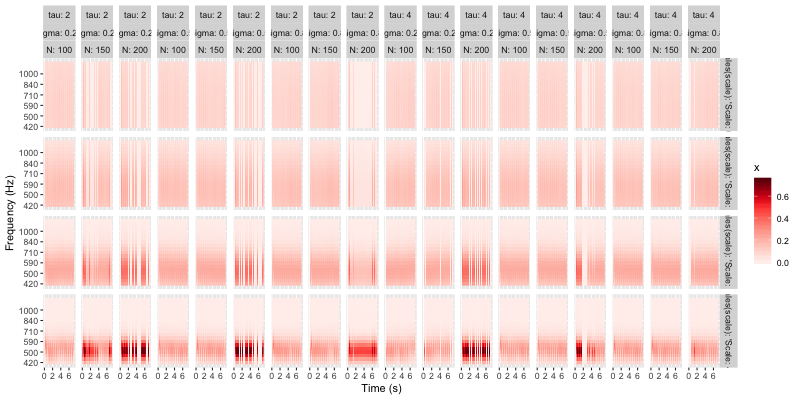

RObject{VecSxp}


In [105]:
rplot(result[1].sources.tracks)

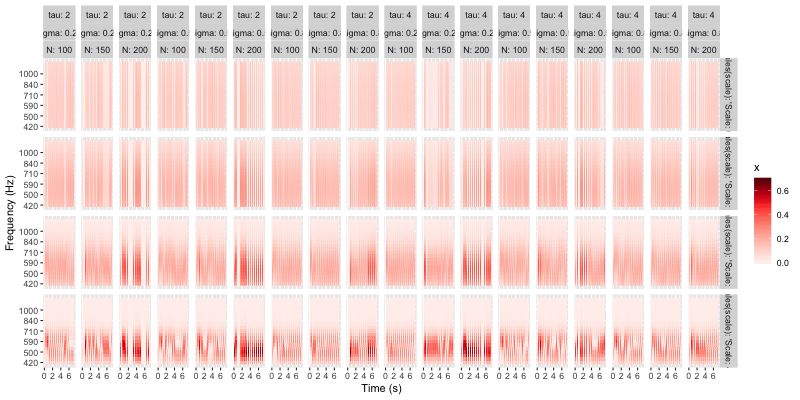

RObject{VecSxp}


In [106]:
rplot(result[2].sources.tracks)

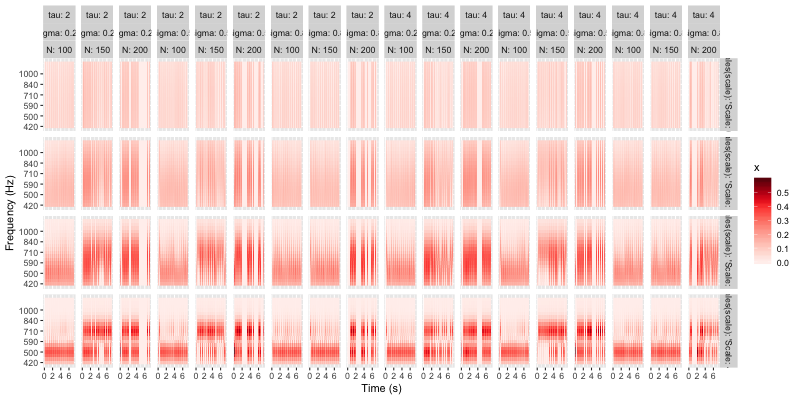

RObject{VecSxp}


In [107]:
rplot(result[3].sources.tracks)

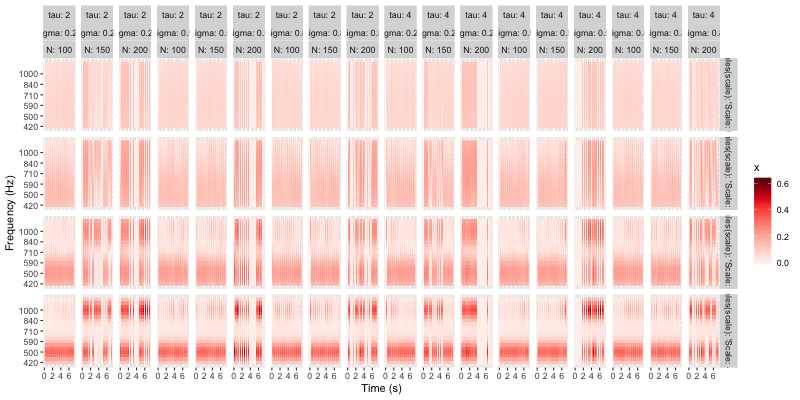

RObject{VecSxp}


In [108]:
rplot(result[4].sources.tracks)

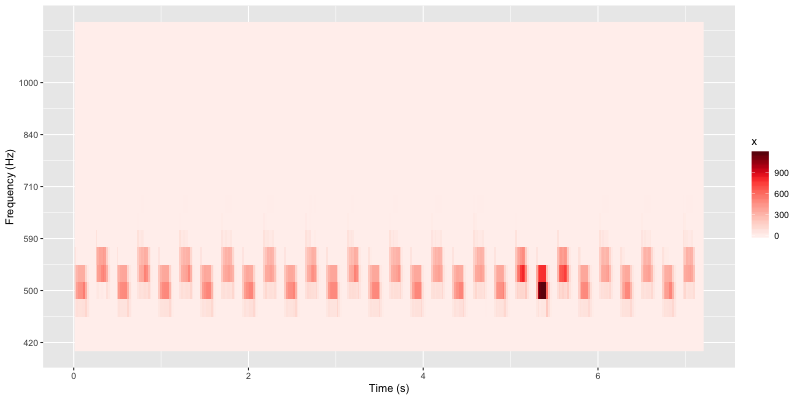

RObject{VecSxp}


In [109]:
rplot(result[1].primary_source)

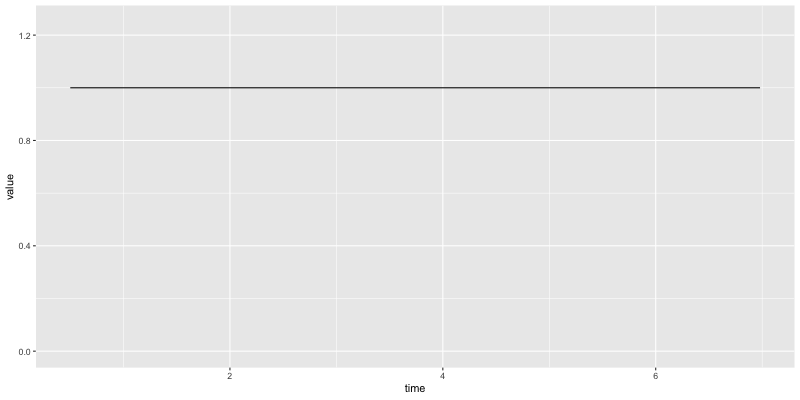

RObject{VecSxp}


In [110]:
p = rplot(result[1].percepts.bratio)
R"""$p + ylim(0.0,1.25)"""

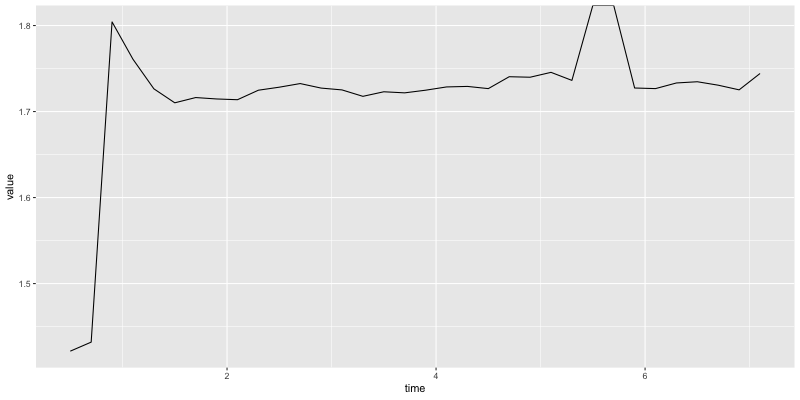

RObject{VecSxp}


In [111]:
rplot(result[1].percepts.sratio)

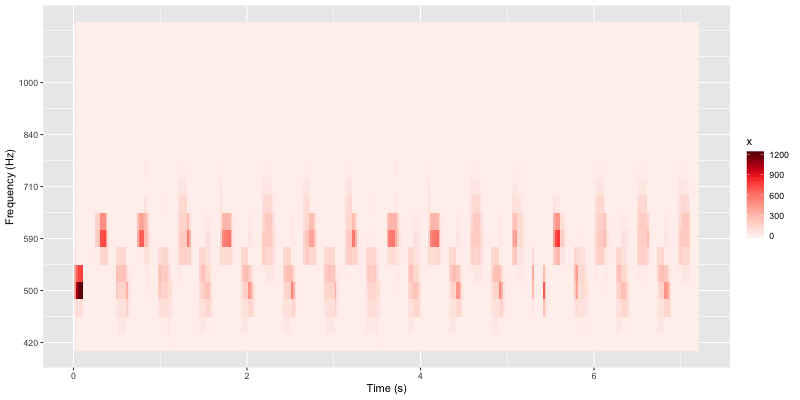

RObject{VecSxp}


In [112]:
rplot(result[2].primary_source)

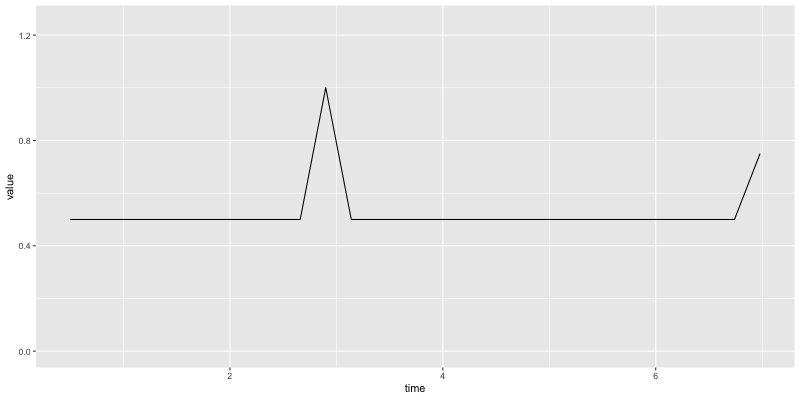

RObject{VecSxp}


In [113]:
p = rplot(result[2].percepts.bratio)
R"$p + ylim(0.0,1.25)"

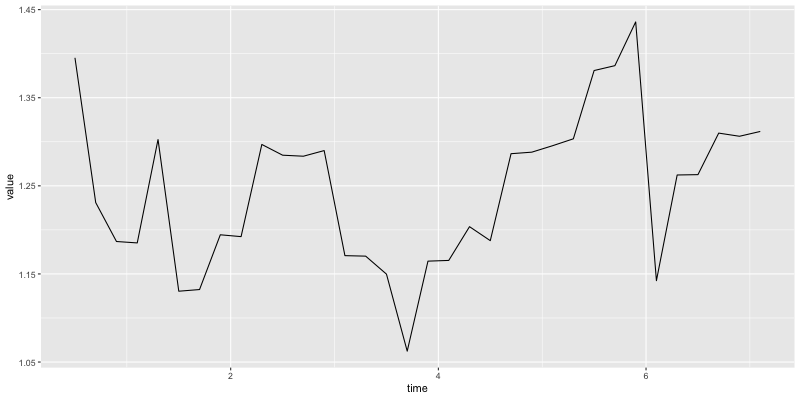

RObject{VecSxp}


In [114]:
rplot(result[2].percepts.sratio)

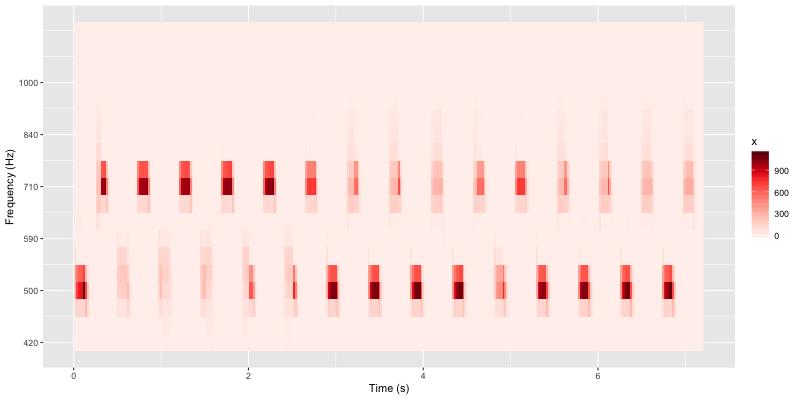

RObject{VecSxp}


In [115]:
rplot(result[3].primary_source)

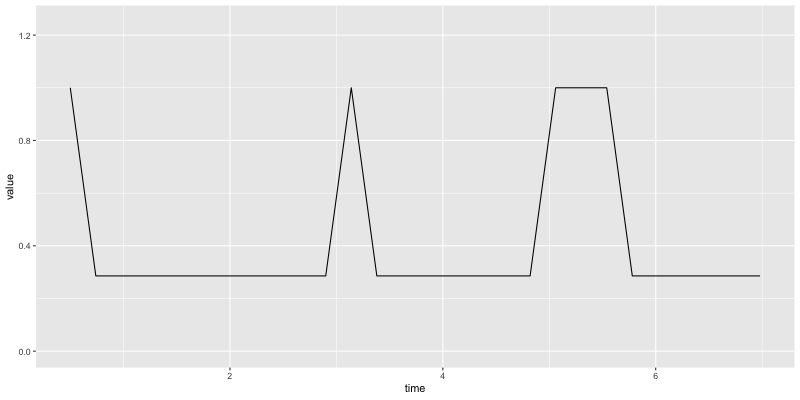

RObject{VecSxp}


In [116]:
p = rplot(result[3].percepts.bratio)
R"$p + ylim(0.0,1.25)"

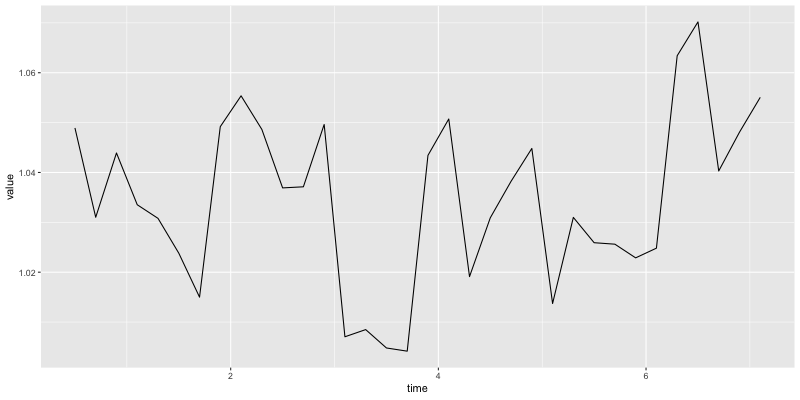

RObject{VecSxp}


In [117]:
rplot(result[3].percepts.sratio)

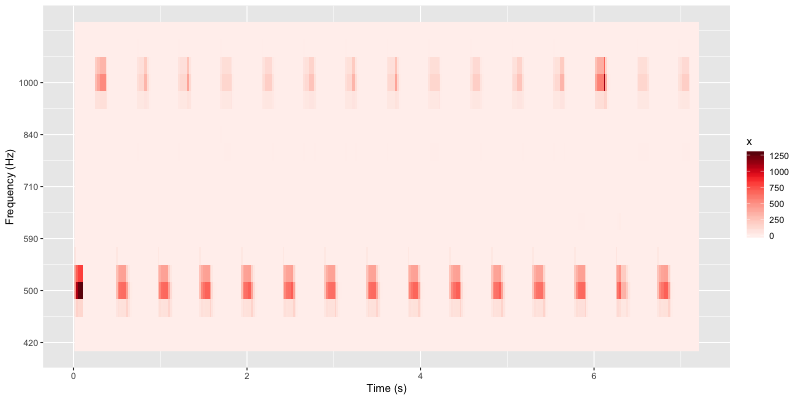

RObject{VecSxp}


In [118]:
rplot(result[4].primary_source)

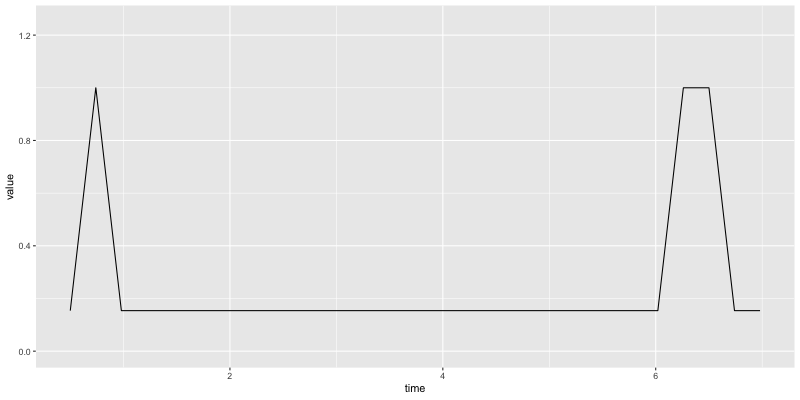

RObject{VecSxp}


In [119]:
p = rplot(result[4].percepts.bratio)
R"$p + ylim(0.0,1.25)"

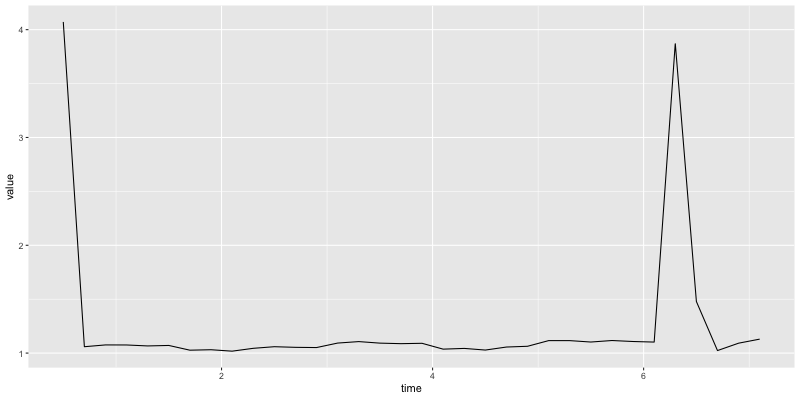

RObject{VecSxp}


In [120]:
rplot(result[4].percepts.sratio)

# longer run

In [121]:
result = []
for d in [1,3,6,12]
    @show d
    params[:Δf] = d
    push!(result,@time(bistable_model(100,params,settings,progressbar=false,
                                      intermediate_results=true)))
end

alert()

d = 1


┌ Info: 21.04% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


 11.776777 seconds (21.73 M allocations: 9.286 GiB, 15.71% gc time)
d = 3


┌ Info: 3.75% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


 10.598136 seconds (21.70 M allocations: 9.285 GiB, 16.99% gc time)
d = 6


┌ Info: 1.04% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


 10.655036 seconds (21.73 M allocations: 9.284 GiB, 15.52% gc time)
d = 12


┌ Info: 1.25% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


 10.671274 seconds (21.72 M allocations: 9.285 GiB, 16.64% gc time)


Process(`osascript -e 'display notification "Done!" with title "Julia"'`, ProcessExited(0))

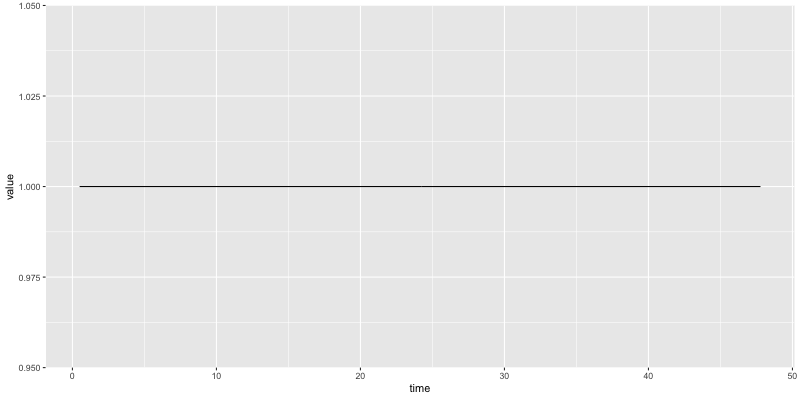

RObject{VecSxp}


In [122]:
rplot(result[1].percepts.bratio)

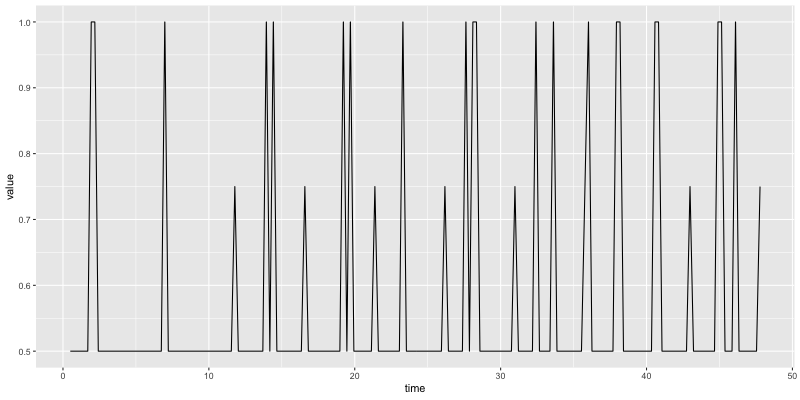

RObject{VecSxp}


In [123]:
rplot(result[2].percepts.bratio)

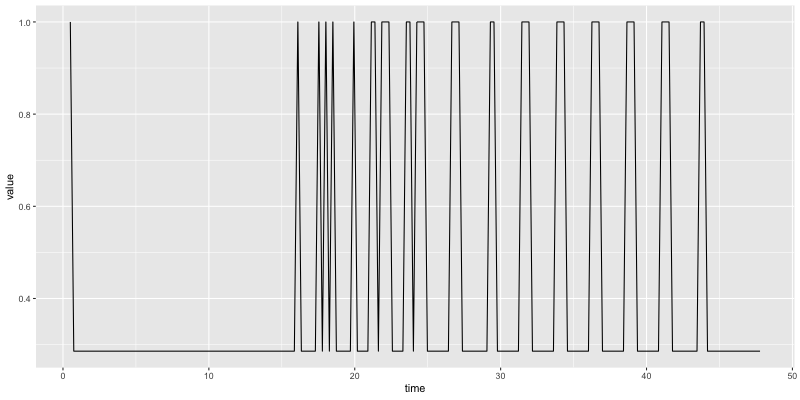

RObject{VecSxp}


In [124]:
rplot(result[3].percepts.bratio)

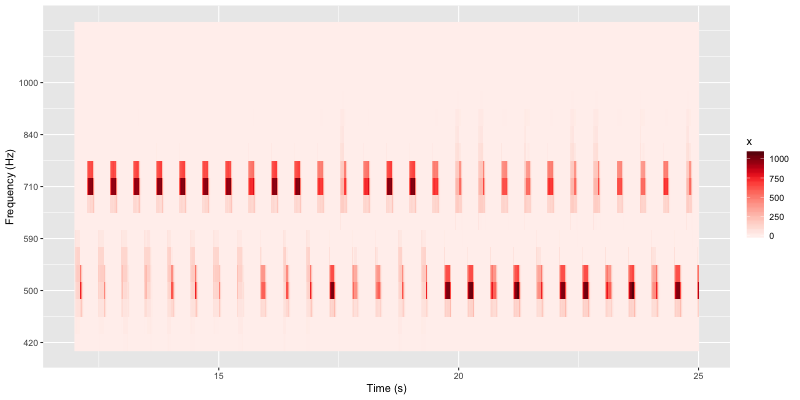

RObject{VecSxp}


In [127]:
rplot(result[3].primary_source[12s .. 25s])

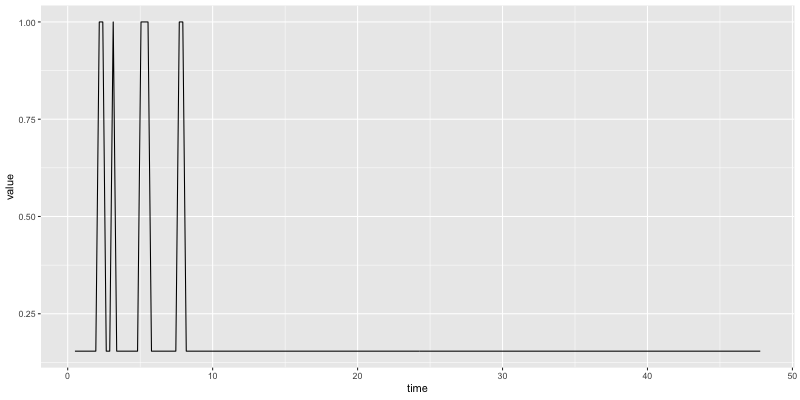

RObject{VecSxp}


In [128]:
rplot(result[4].percepts.bratio)

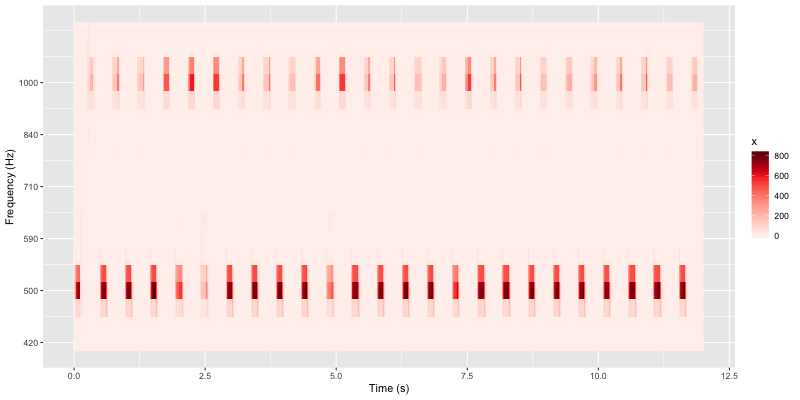

RObject{VecSxp}


In [129]:
rplot(result[4].primary_source[0s .. 12s])

# thoughts

This seems to be essentially working at this point, with the bratio reports being consistent with the spectrums. The sratio value is essentially useless (I believe becuase of the normalization).

There is a small question of whether the competition setup between all *three* different hyperparameters is appropriate, and whether we should vary all three. (Maybe we can get away with 1 or 2). 

However, before I answer these questions I want to get a sense of how well this works across all three types of models.

# Freq-level Bistability

# Scale-level Bistability 

# Pairing down hyperparameters 